In [ ]:
!pip install meteostat --quiet
!pip install pandas_market_calendars


In [ ]:
import pandas as pd
import requests
from datetime import datetime, timedelta
from meteostat import Stations, Daily
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas_market_calendars as mcal

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [ ]:
def load_weather(city, start, end):
    lat, lon = CITY_COORDS[city]
    station = Stations().nearby(lat, lon).fetch(1).index[0]
    df = Daily(station, start, end).fetch()
    df = df[['tmin','tmax','prcp','snow']].rename(
        columns={'tmin':'temp_min','tmax':'temp_max','prcp':'precip','snow':'snow'}
    )
    df.index = df.index.tz_localize(None).normalize()
    return df


def load_stock(ticker, key, start, end):
    url = 'https://www.alphavantage.co/query'
    params = {'function':'TIME_SERIES_DAILY','symbol':ticker,
              'outputsize':'full','apikey':key}
    r = requests.get(url, params=params)
    r.raise_for_status()
    ts = r.json().get('Time Series (Daily)', {})
    df = pd.DataFrame.from_dict(ts, orient='index').apply(pd.to_numeric, errors='coerce')
    df = df[['4. close']].rename(columns={'4. close':'stock_close'})
    df.index = pd.to_datetime(df.index).normalize()
    return df.loc[(df.index>=start)&(df.index<=end)].sort_index()




def get_weather_and_stock(city, ticker, start=START_DATE, end=START_DATE):
    weather_df = load_weather(city, start=START_DATE, end=END_DATE)
    idx = weather_df.index.dropna()
    if idx.empty:
        print(f"Weather data for {city} is invalid. Skipping.")
        return None, None

    # get trading days
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.schedule(start_date=idx.min(), end_date=idx.max())
    trading_days = trading_days.index

    # get weather data
    agg = []
    prev = trading_days[0] - timedelta(days=1)
    for today in trading_days:
        period = weather_df.loc[(weather_df.index > prev) & (weather_df.index <= today)]
        agg.append({
            'date': today,
            'temp_min_mean': period['temp_min'].mean(),
            'temp_max_mean': period['temp_max'].mean(),
            'precip_sum':      period['precip'].sum(),
            'snow_sum':        period['snow'].sum()
        })
        prev = today
    weather_agg = pd.DataFrame(agg).set_index('date')

    # get stock data
    stock_df = STOCK_DATA[ticker].copy()
    return weather_agg, stock_df


def get_dataset(city, ticker, weather=True, lag_days=5, future_days=None):

    weather_agg, stock_df = get_weather_and_stock(city, ticker)
    if weather_agg is None or stock_df is None:
        return None, None

    stock_with_weather = stock_df.join(weather_agg, how='inner')
    for lag in range(1, lag_days+1):
        stock_with_weather[f'stock_lag_{lag}']      = stock_with_weather['stock_close'].shift(lag)
        stock_with_weather[f'tmin_mean_lag_{lag}']  = stock_with_weather['temp_min_mean'].shift(lag)
        stock_with_weather[f'tmax_mean_lag_{lag}']  = stock_with_weather['temp_max_mean'].shift(lag)
        stock_with_weather[f'precip_sum_lag_{lag}'] = stock_with_weather['precip_sum'].shift(lag)
        stock_with_weather[f'snow_sum_lag_{lag}']   = stock_with_weather['snow_sum'].shift(lag)

    if future_days:
        for lead in range(1, future_days + 1):
            stock_with_weather[f'tmin_mean_future_{lead}'] = stock_with_weather['temp_min_mean'].shift(-lead)
            stock_with_weather[f'tmax_mean_future_{lead}'] = stock_with_weather['temp_max_mean'].shift(-lead)
            stock_with_weather[f'precip_sum_future_{lead}'] = stock_with_weather['precip_sum'].shift(-lead)
            stock_with_weather[f'snow_sum_future_{lead}'] = stock_with_weather['snow_sum'].shift(-lead)

    stock_with_weather = stock_with_weather.dropna()
    if df2.empty:
        print(f"No matching dates between stock and weather data for {city}-{ticker}. Skipping.")
        return None, None

    if not weather:
        weather_cols = [col for col in stock_with_weather.columns if any(key in col for key in ['tmin_mean', 'tmax_mean', 'precip_sum', 'snow_sum'])]
        stock_without_weather = stock_with_weather.copy()
        stock_without_weather.loc[:, weather_cols] = 0.0
        X = stock_without_weather.drop('stock_close', axis=1)
    else:

        X = stock_with_weather.drop('stock_close', axis=1)
    y = stock_with_weather['stock_close']
    return X, y

def get_dataset_with_labels(city, ticker, weather=True, lag_days=5, future_days=None, label_window=5, threshold=0.05):
    """
    Generate a classification dataset where the target is a 3-class label:
    'up', 'down', or 'flat', based on future price movements.

    Parameters:
    - city: location for weather data
    - ticker: stock symbol
    - weather: whether to include weather features
    - lag_days: number of past days used for lagged features
    - future_days: number of future days used for weather features (optional)
    - label_window: number of days ahead to check for price movement
    - threshold: percentage change to define 'up' or 'down' movement

    Returns:
    - X: DataFrame of features
    - y_class: Series of classification labels
    """
    # Get feature matrix and regression target from existing pipeline
    X, y = get_dataset(city, ticker, weather=weather, lag_days=lag_days, future_days=future_days)
    if X is None or y is None:
        return None, None

    closes = y.values
    labels = []

    # Generate classification labels based on future price movements
    for i in range(len(closes)):
        if i + label_window >= len(closes):
            labels.append(np.nan)
            continue

        current_price = closes[i]
        future_prices = closes[i + 1 : i + 1 + label_window]
        max_future = np.max(future_prices)
        min_future = np.min(future_prices)

        if max_future >= current_price * (1 + threshold):
            labels.append('up')
        elif min_future <= current_price * (1 - threshold):
            labels.append('down')
        else:
            labels.append('flat')

    # Create label series and align with features
    y_class = pd.Series(labels, index=y.index)
    X = X.loc[y_class.dropna().index]
    y_class = y_class.dropna()

    return X, y_class






## models

### ml models

In [ ]:
def get_ml_results(city, tickers, weather=True, lag_days=5, future_days=None, label_window=5, threshold=0.05, algorithm="RandomForestClassifier"):
    X, y_class = get_dataset_with_labels(city, tickers, weather=weather, lag_days=lag_days, future_days=future_days, label_window=label_window, threshold=threshold)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_class)  # 'down'->0, 'flat'->1, 'up'->2

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )

    # Train a Random Forest classifier
    if algorithm == "RandomForestClassifier":
        clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Generate a classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    # Plot a confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Random Forest)')
    plt.tight_layout()
    plt.show()

def train_onehot_mlp_classifier(X, y_class, hidden_layer_sizes=(64,), test_size=0.2, random_state=42):
    """
    Train an MLP classifier with one-hot encoded labels, print evaluation,
    and return structured evaluation results.

    Parameters:
    - X: feature DataFrame
    - y_class: string labels ('up', 'down', 'flat')
    - hidden_layer_sizes: architecture of MLP
    - test_size: test set split ratio
    - random_state: reproducibility

    Returns:
    - clf: trained classifier
    - encoder: fitted OneHotEncoder
    - report_df: pandas DataFrame of classification report
    """
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Encode labels to one-hot, then to integers
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_class.values.reshape(-1, 1))
    y_int = np.argmax(y_onehot, axis=1)
    label_names = encoder.categories_[0]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_int, test_size=test_size, random_state=random_state
    )

    # Model training
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu',
                        max_iter=300, random_state=random_state)
    clf.fit(X_train, y_train)

    # Prediction
    y_pred = clf.predict(X_test)

    # Classification Report (dict and DataFrame)
    report_dict = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Confusion matrix plot
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (MLP Classifier)')
    plt.tight_layout()
    plt.show()

    return clf, encoder, report_df




### deep learning models

In [350]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, num_classes=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: [B, input_dim] → reshape to [B, 1, input_dim] to simulate seq
        x = x.unsqueeze(1)
        out, (h_n, c_n) = self.lstm(x)     # out: [B, 1, H], h_n: [1, B, H]
        out = self.dropout(h_n[-1])        # take last layer hidden state
        return self.fc(out)                # [B, num_classes]

In [349]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # [batch, seq_len=1, d_model]
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x)

def get_datasets_for_dl(X, y_class):

    encoder = OneHotEncoder(sparse_output=False)
    y_encoded = encoder.fit_transform(y_class.to_numpy().reshape(-1, 1))
    y_int = np.argmax(y_encoded, axis=1)
    label_names = encoder.categories_[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42)
    train_dataset = StockDataset(X_train, y_train)
    test_dataset = StockDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    return train_loader, test_loader, label_names


def train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

    # 8. Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            preds = model(batch_X).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.numpy())

    # 9. Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))


    cm = confusion_matrix(all_labels, all_preds)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()




In [ ]:
import torch
import torch.nn as nn

class CrossAttentionModel(nn.Module):
    def __init__(self, price_dim, weather_dim, d_model=64, num_heads=4, dropout=0.1, num_classes=3):
        super().__init__()

        # Linear embeddings for price and weather
        self.price_proj = nn.Linear(price_dim, d_model)
        self.weather_proj = nn.Linear(weather_dim, d_model)

        # Cross attention: query from price, key/value from weather
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)

        # Optional: feedforward block
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: [batch, total_features] where total = price + weather
        x_price = x[:, :5]     # e.g., first 5 features are stock prices
        x_weather = x[:, 5:]   # rest are weather features

        # project to embedding space
        q = self.price_proj(x_price).unsqueeze(1)    # [B, 1, d_model]
        k = self.weather_proj(x_weather).unsqueeze(1)  # [B, 1, d_model]
        v = k.clone()

        # Apply cross-attention: price attends to weather
        attn_output, _ = self.cross_attn(q, k, v)     # [B, 1, d_model]

        # Apply feedforward and classification
        out = self.ffn(attn_output).squeeze(1)        # [B, d_model]
        return self.classifier(out)                   # [B, num_classes]


## ML Results

In [ ]:
# API_KEY = 'ALOPQH28XCLCD2PP'
API_KEY = '665X5CPYMVJVLL81'
START_DATE = datetime(2016, 7, 21)
END_DATE   = datetime(2025, 2, 28)
CITY_COORDS = {
    'New York, NY':    (40.7128, -74.0060),
    'Chicago, IL':     (41.8781, -87.6298),
    'Dallas, TX':      (32.7767, -96.7970),
    'Boston, MA':      (42.3601, -71.0589),
    'Minneapolis, MN': (44.9778, -93.2650)
}

cities  = list(CITY_COORDS.keys())
tickers = ['UNG', 'UNL']

STOCK_DATA = {}
for ticker in tickers:
    STOCK_DATA[ticker] = load_stock(ticker, API_KEY, START_DATE, END_DATE)





              precision    recall  f1-score   support

        down       0.50      0.52      0.51       124
        flat       0.57      0.62      0.59       133
          up       0.58      0.50      0.54       127

    accuracy                           0.55       384
   macro avg       0.55      0.55      0.55       384
weighted avg       0.55      0.55      0.55       384



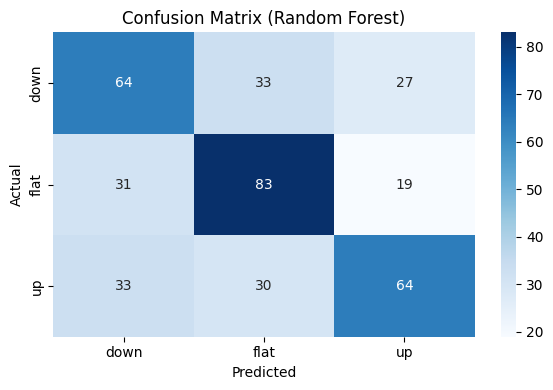

In [ ]:
get_ml_results(cities[0], tickers[0], weather=False, lag_days=5, future_days=None, label_window=5, threshold=0.05, algorithm="RandomForestClassifier")

              precision    recall  f1-score   support

        down       0.49      0.55      0.52       124
        flat       0.61      0.63      0.62       133
          up       0.56      0.48      0.52       127

    accuracy                           0.55       384
   macro avg       0.56      0.55      0.55       384
weighted avg       0.56      0.55      0.55       384



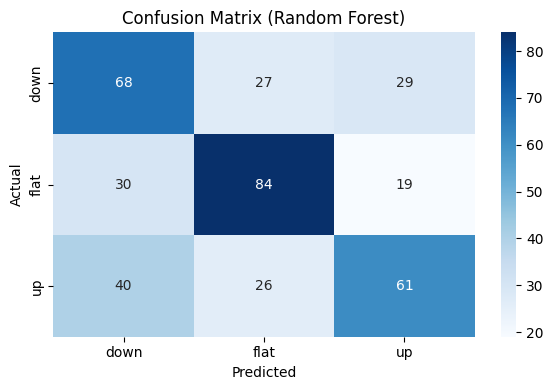

In [ ]:
get_ml_results(cities[0], tickers[0], weather=True, lag_days=5, future_days=None, label_window=5, threshold=0.05, algorithm="RandomForestClassifier")

## MLP results (one-hot)

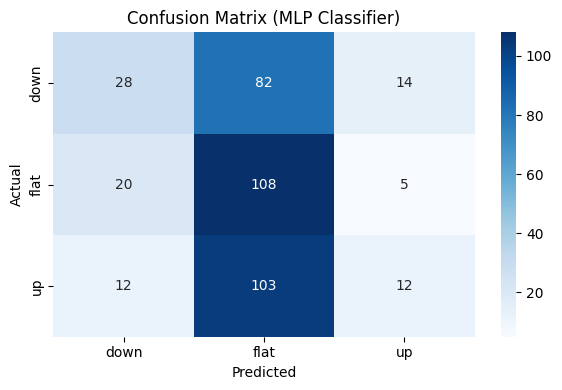

              precision    recall  f1-score     support
down           0.466667  0.225806  0.304348  124.000000
flat           0.368601  0.812030  0.507042  133.000000
up             0.387097  0.094488  0.151899  127.000000
accuracy       0.385417  0.385417  0.385417    0.385417
macro avg      0.407455  0.377442  0.321096  384.000000
weighted avg   0.406385  0.385417  0.324133  384.000000


In [ ]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=False, label_window=5, threshold=0.05)
clf, encoder, report_df = train_onehot_mlp_classifier(X, y_class, hidden_layer_sizes=(256, 128, 128), test_size=0.2, random_state=42)
print(report_df)

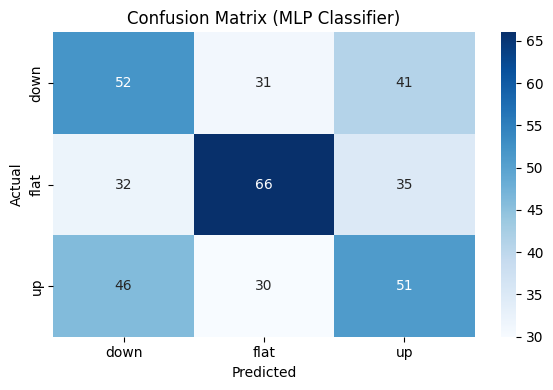

              precision    recall  f1-score     support
down           0.400000  0.419355  0.409449  124.000000
flat           0.519685  0.496241  0.507692  133.000000
up             0.401575  0.401575  0.401575  127.000000
accuracy       0.440104  0.440104  0.440104    0.440104
macro avg      0.440420  0.439057  0.439572  384.000000
weighted avg   0.441974  0.440104  0.440872  384.000000


In [ ]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05)
clf, encoder, report_df = train_onehot_mlp_classifier(X, y_class, hidden_layer_sizes=(256, 128, 128), test_size=0.2, random_state=42)
print(report_df)

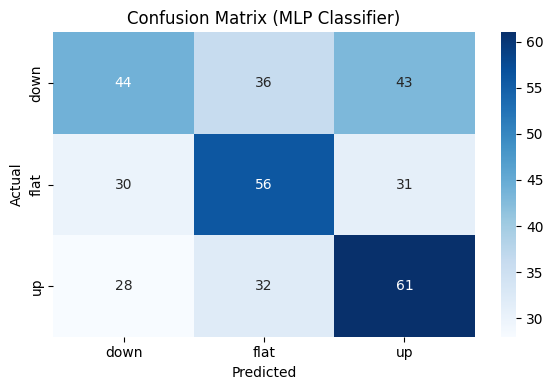

              precision    recall  f1-score     support
down           0.431373  0.357724  0.391111  123.000000
flat           0.451613  0.478632  0.464730  117.000000
up             0.451852  0.504132  0.476562  121.000000
accuracy       0.445983  0.445983  0.445983    0.445983
macro avg      0.444946  0.446829  0.444135  361.000000
weighted avg   0.444797  0.445983  0.443613  361.000000


In [ ]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05, future_days=5)
clf, encoder, report_df = train_onehot_mlp_classifier(X, y_class, hidden_layer_sizes=(512, 256, 128), test_size=0.2, random_state=42)
print(report_df)

## LSTM

Epoch 1 - Loss: 52.4422
Epoch 2 - Loss: 52.3729
Epoch 3 - Loss: 52.0487
Epoch 4 - Loss: 51.8963
Epoch 5 - Loss: 52.0105
Epoch 6 - Loss: 51.7865
Epoch 7 - Loss: 51.8041
Epoch 8 - Loss: 51.7280
Epoch 9 - Loss: 51.8121
Epoch 10 - Loss: 51.6519
Epoch 11 - Loss: 51.5251
Epoch 12 - Loss: 51.6995
Epoch 13 - Loss: 51.5463
Epoch 14 - Loss: 51.6226
Epoch 15 - Loss: 51.7845
Epoch 16 - Loss: 51.4844
Epoch 17 - Loss: 51.5756
Epoch 18 - Loss: 51.5457
Epoch 19 - Loss: 51.6632
Epoch 20 - Loss: 51.4696
Epoch 21 - Loss: 51.5359
Epoch 22 - Loss: 51.4898
Epoch 23 - Loss: 51.4373
Epoch 24 - Loss: 51.4948
Epoch 25 - Loss: 51.4951
Epoch 26 - Loss: 51.4296
Epoch 27 - Loss: 51.4199
Epoch 28 - Loss: 51.4236
Epoch 29 - Loss: 51.1949
Epoch 30 - Loss: 51.3948
Epoch 31 - Loss: 51.2448
Epoch 32 - Loss: 51.5440
Epoch 33 - Loss: 51.3712
Epoch 34 - Loss: 51.4392
Epoch 35 - Loss: 51.3224
Epoch 36 - Loss: 51.4289
Epoch 37 - Loss: 51.4128
Epoch 38 - Loss: 51.1632
Epoch 39 - Loss: 51.1489
Epoch 40 - Loss: 51.3388
Epoch 41 

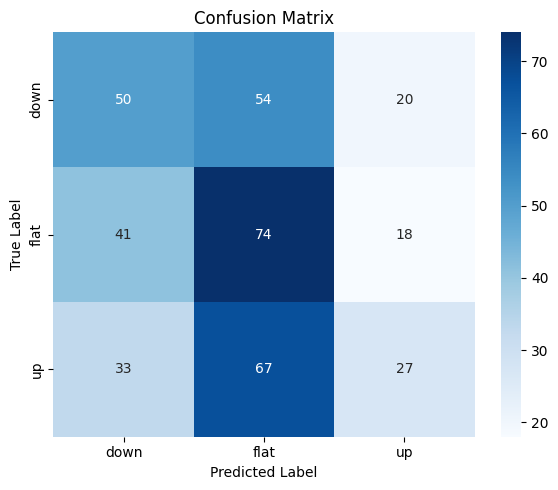

In [386]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=False, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = LSTMClassifier(input_dim=X.shape[1], num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)


Epoch 1 - Loss: 52.6253
Epoch 2 - Loss: 51.6015
Epoch 3 - Loss: 50.8968
Epoch 4 - Loss: 50.2968
Epoch 5 - Loss: 49.9608
Epoch 6 - Loss: 49.4783
Epoch 7 - Loss: 49.4418
Epoch 8 - Loss: 48.7355
Epoch 9 - Loss: 48.4640
Epoch 10 - Loss: 48.3551
Epoch 11 - Loss: 47.7254
Epoch 12 - Loss: 47.4780
Epoch 13 - Loss: 47.4965
Epoch 14 - Loss: 46.9413
Epoch 15 - Loss: 47.0636
Epoch 16 - Loss: 46.9781
Epoch 17 - Loss: 46.4395
Epoch 18 - Loss: 46.2999
Epoch 19 - Loss: 46.0058
Epoch 20 - Loss: 45.7189
Epoch 21 - Loss: 46.0482
Epoch 22 - Loss: 45.2477
Epoch 23 - Loss: 45.0541
Epoch 24 - Loss: 44.6288
Epoch 25 - Loss: 44.9628
Epoch 26 - Loss: 44.4760
Epoch 27 - Loss: 44.2868
Epoch 28 - Loss: 44.0296
Epoch 29 - Loss: 43.5726
Epoch 30 - Loss: 43.2627
Epoch 31 - Loss: 43.1361
Epoch 32 - Loss: 43.3648
Epoch 33 - Loss: 43.3643
Epoch 34 - Loss: 42.6852
Epoch 35 - Loss: 43.1801
Epoch 36 - Loss: 42.5599
Epoch 37 - Loss: 41.8167
Epoch 38 - Loss: 41.9964
Epoch 39 - Loss: 42.1440
Epoch 40 - Loss: 41.4486
Epoch 41 

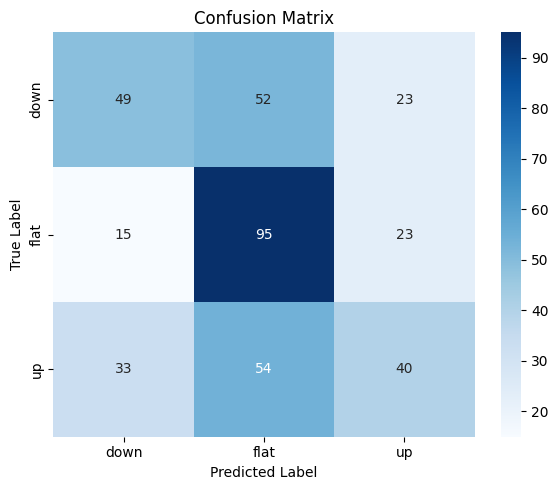

In [352]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = LSTMClassifier(input_dim=X.shape[1], num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 47.5170
Epoch 2 - Loss: 46.0961
Epoch 3 - Loss: 45.5499
Epoch 4 - Loss: 44.9426
Epoch 5 - Loss: 44.0219
Epoch 6 - Loss: 43.5127
Epoch 7 - Loss: 42.7634
Epoch 8 - Loss: 41.9115
Epoch 9 - Loss: 41.6741
Epoch 10 - Loss: 41.1983
Epoch 11 - Loss: 40.1014
Epoch 12 - Loss: 40.1250
Epoch 13 - Loss: 38.9193
Epoch 14 - Loss: 38.3566
Epoch 15 - Loss: 38.3057
Epoch 16 - Loss: 37.1967
Epoch 17 - Loss: 36.9591
Epoch 18 - Loss: 36.6334
Epoch 19 - Loss: 36.4596
Epoch 20 - Loss: 35.6761
Epoch 21 - Loss: 34.6593
Epoch 22 - Loss: 34.7684
Epoch 23 - Loss: 33.9452
Epoch 24 - Loss: 33.5978
Epoch 25 - Loss: 33.0666
Epoch 26 - Loss: 32.6981
Epoch 27 - Loss: 31.6608
Epoch 28 - Loss: 31.4458
Epoch 29 - Loss: 31.3462
Epoch 30 - Loss: 31.0032
Epoch 31 - Loss: 30.6006
Epoch 32 - Loss: 30.3806
Epoch 33 - Loss: 30.4969
Epoch 34 - Loss: 30.2074
Epoch 35 - Loss: 29.1719
Epoch 36 - Loss: 29.7081
Epoch 37 - Loss: 28.6603
Epoch 38 - Loss: 28.3070
Epoch 39 - Loss: 28.4683
Epoch 40 - Loss: 27.8397
Epoch 41 

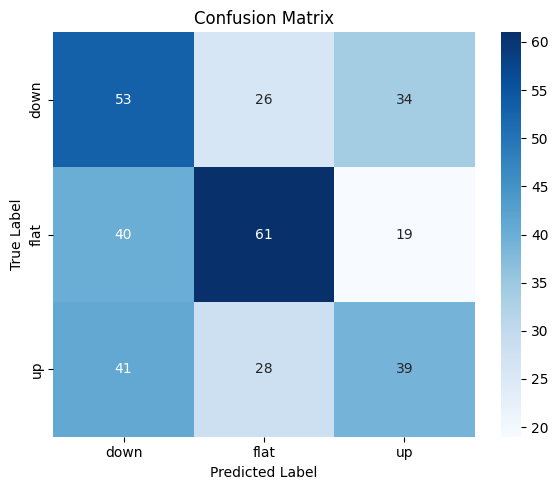

In [353]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05, future_days=10)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = LSTMClassifier(input_dim=X.shape[1], num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

In [370]:
cities

['New York, NY', 'Chicago, IL', 'Dallas, TX', 'Boston, MA', 'Minneapolis, MN']

Epoch 1 - Loss: 59.2267
Epoch 2 - Loss: 58.0097
Epoch 3 - Loss: 57.5095
Epoch 4 - Loss: 56.7340
Epoch 5 - Loss: 55.9049
Epoch 6 - Loss: 55.6730
Epoch 7 - Loss: 55.5040
Epoch 8 - Loss: 54.5425
Epoch 9 - Loss: 54.1706
Epoch 10 - Loss: 53.3525
Epoch 11 - Loss: 52.8080
Epoch 12 - Loss: 52.1946
Epoch 13 - Loss: 51.8370
Epoch 14 - Loss: 50.9120
Epoch 15 - Loss: 51.2362
Epoch 16 - Loss: 50.2011
Epoch 17 - Loss: 50.0053
Epoch 18 - Loss: 49.2888
Epoch 19 - Loss: 49.5043
Epoch 20 - Loss: 49.1223
Epoch 21 - Loss: 48.1316
Epoch 22 - Loss: 47.7733
Epoch 23 - Loss: 47.2994
Epoch 24 - Loss: 47.0169
Epoch 25 - Loss: 46.5465
Epoch 26 - Loss: 46.4102
Epoch 27 - Loss: 45.8615
Epoch 28 - Loss: 45.4436
Epoch 29 - Loss: 44.7396
Epoch 30 - Loss: 44.7299
Epoch 31 - Loss: 44.5321
Epoch 32 - Loss: 43.8267
Epoch 33 - Loss: 44.0600
Epoch 34 - Loss: 42.8360
Epoch 35 - Loss: 43.5039
Epoch 36 - Loss: 42.8034
Epoch 37 - Loss: 41.8917
Epoch 38 - Loss: 41.5102
Epoch 39 - Loss: 41.1613
Epoch 40 - Loss: 41.4278
Epoch 41 

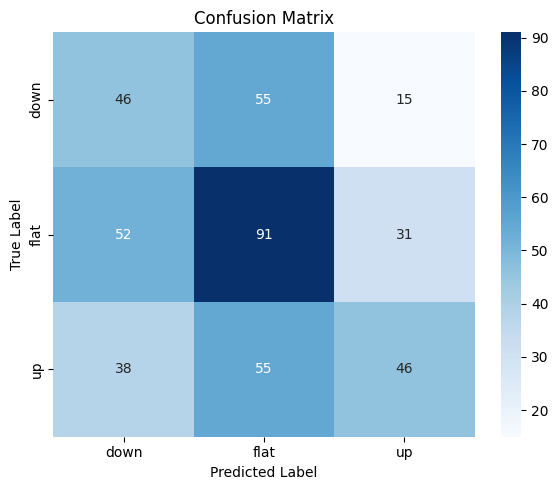

In [373]:
X, y_class = get_dataset_with_labels(cities[2], "UNG", weather=True, label_window=5, threshold=0.05, future_days=10)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = LSTMClassifier(input_dim=X.shape[1], num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 57.5883
Epoch 2 - Loss: 56.0843
Epoch 3 - Loss: 55.4514
Epoch 4 - Loss: 54.7622
Epoch 5 - Loss: 54.5513
Epoch 6 - Loss: 54.0322
Epoch 7 - Loss: 53.3518
Epoch 8 - Loss: 53.2237
Epoch 9 - Loss: 52.5947
Epoch 10 - Loss: 51.9331
Epoch 11 - Loss: 51.6626
Epoch 12 - Loss: 51.3008
Epoch 13 - Loss: 51.0791
Epoch 14 - Loss: 50.7910
Epoch 15 - Loss: 50.6011
Epoch 16 - Loss: 50.6285
Epoch 17 - Loss: 49.4543
Epoch 18 - Loss: 49.1135
Epoch 19 - Loss: 48.7932
Epoch 20 - Loss: 47.8785
Epoch 21 - Loss: 48.1871
Epoch 22 - Loss: 47.8056
Epoch 23 - Loss: 46.6779
Epoch 24 - Loss: 47.3411
Epoch 25 - Loss: 46.6425
Epoch 26 - Loss: 46.6369
Epoch 27 - Loss: 45.8678
Epoch 28 - Loss: 46.1229
Epoch 29 - Loss: 45.5004
Epoch 30 - Loss: 44.7797
Epoch 31 - Loss: 44.1034
Epoch 32 - Loss: 43.9804
Epoch 33 - Loss: 43.0242
Epoch 34 - Loss: 43.2119
Epoch 35 - Loss: 42.2766
Epoch 36 - Loss: 42.4974
Epoch 37 - Loss: 42.1189
Epoch 38 - Loss: 41.7951
Epoch 39 - Loss: 41.6732
Epoch 40 - Loss: 41.4623
Epoch 41 

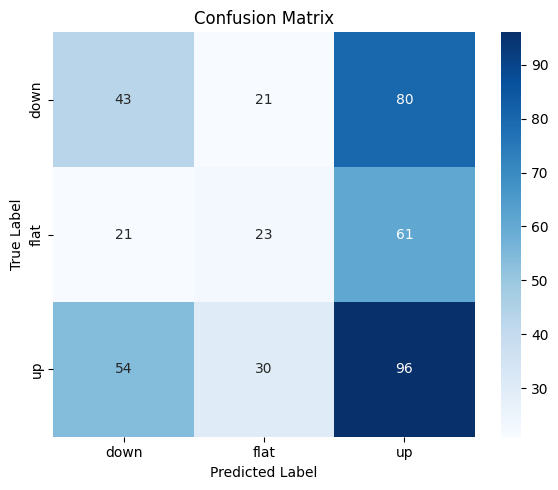

In [376]:
X, y_class = get_dataset_with_labels(cities[2], "UNL", weather=True, label_window=5, threshold=0.02, future_days=10)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = LSTMClassifier(input_dim=X.shape[1], num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

## transformer

Epoch 1 - Loss: 53.9116
Epoch 2 - Loss: 52.6518
Epoch 3 - Loss: 52.7669
Epoch 4 - Loss: 52.6405
Epoch 5 - Loss: 52.5440
Epoch 6 - Loss: 52.7837
Epoch 7 - Loss: 52.4744
Epoch 8 - Loss: 52.2518
Epoch 9 - Loss: 52.2381
Epoch 10 - Loss: 52.2773
Epoch 11 - Loss: 52.1362
Epoch 12 - Loss: 52.2797
Epoch 13 - Loss: 52.2099
Epoch 14 - Loss: 52.2085
Epoch 15 - Loss: 52.1425
Epoch 16 - Loss: 52.1510
Epoch 17 - Loss: 52.0651
Epoch 18 - Loss: 52.2681
Epoch 19 - Loss: 52.2394
Epoch 20 - Loss: 52.1166
Epoch 21 - Loss: 52.0129
Epoch 22 - Loss: 51.9742
Epoch 23 - Loss: 52.0378
Epoch 24 - Loss: 52.0040
Epoch 25 - Loss: 51.9648
Epoch 26 - Loss: 51.8876
Epoch 27 - Loss: 52.4149
Epoch 28 - Loss: 52.1575
Epoch 29 - Loss: 52.1029
Epoch 30 - Loss: 51.9124
Epoch 31 - Loss: 52.0627
Epoch 32 - Loss: 52.0569
Epoch 33 - Loss: 51.9510
Epoch 34 - Loss: 51.8742
Epoch 35 - Loss: 51.9901
Epoch 36 - Loss: 51.9616
Epoch 37 - Loss: 52.2473
Epoch 38 - Loss: 51.9686
Epoch 39 - Loss: 51.8576
Epoch 40 - Loss: 51.7428
Epoch 41 

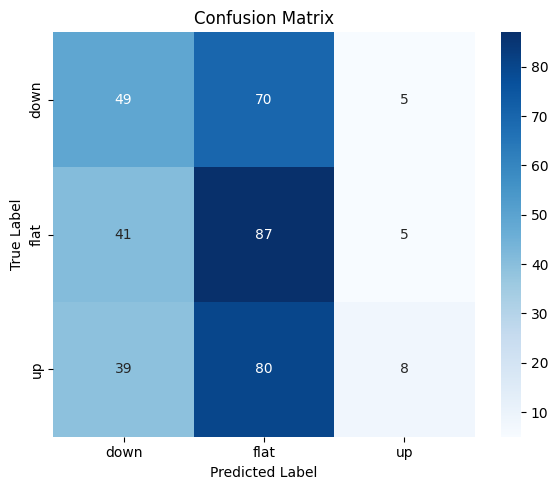

In [354]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=False, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

Epoch 1 - Loss: 53.7628
Epoch 2 - Loss: 52.1598
Epoch 3 - Loss: 52.1004
Epoch 4 - Loss: 51.8959
Epoch 5 - Loss: 51.4023
Epoch 6 - Loss: 51.4126
Epoch 7 - Loss: 50.4751
Epoch 8 - Loss: 50.5858
Epoch 9 - Loss: 50.8361
Epoch 10 - Loss: 50.3734
Epoch 11 - Loss: 50.4828
Epoch 12 - Loss: 49.9026
Epoch 13 - Loss: 50.0364
Epoch 14 - Loss: 49.6700
Epoch 15 - Loss: 49.6225
Epoch 16 - Loss: 49.5720
Epoch 17 - Loss: 49.1803
Epoch 18 - Loss: 48.9119
Epoch 19 - Loss: 48.8257
Epoch 20 - Loss: 48.4494
Epoch 21 - Loss: 48.5359
Epoch 22 - Loss: 48.3370
Epoch 23 - Loss: 47.8840
Epoch 24 - Loss: 48.0371
Epoch 25 - Loss: 47.4463
Epoch 26 - Loss: 46.6804
Epoch 27 - Loss: 47.0026
Epoch 28 - Loss: 46.5989
Epoch 29 - Loss: 47.3661
Epoch 30 - Loss: 46.3306
Epoch 31 - Loss: 45.5880
Epoch 32 - Loss: 46.4235
Epoch 33 - Loss: 45.9133
Epoch 34 - Loss: 45.7162
Epoch 35 - Loss: 45.0918
Epoch 36 - Loss: 45.7224
Epoch 37 - Loss: 44.9804
Epoch 38 - Loss: 44.4634
Epoch 39 - Loss: 44.3365
Epoch 40 - Loss: 44.2111
Epoch 41 

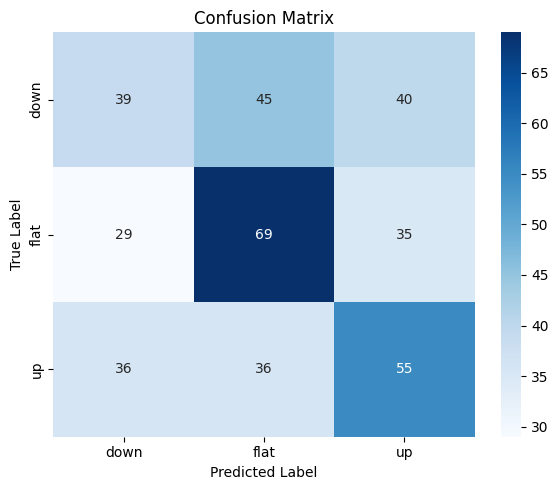

In [355]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

Epoch 1 - Loss: 48.7079
Epoch 2 - Loss: 47.0530
Epoch 3 - Loss: 46.4370
Epoch 4 - Loss: 45.7939
Epoch 5 - Loss: 45.8445
Epoch 6 - Loss: 44.8346
Epoch 7 - Loss: 44.5755
Epoch 8 - Loss: 44.0034
Epoch 9 - Loss: 43.8275
Epoch 10 - Loss: 42.8974
Epoch 11 - Loss: 43.2745
Epoch 12 - Loss: 42.4385
Epoch 13 - Loss: 41.3544
Epoch 14 - Loss: 40.9716
Epoch 15 - Loss: 40.7017
Epoch 16 - Loss: 40.8955
Epoch 17 - Loss: 40.1532
Epoch 18 - Loss: 39.1764
Epoch 19 - Loss: 38.2252
Epoch 20 - Loss: 37.9718
Epoch 21 - Loss: 37.9700
Epoch 22 - Loss: 36.7516
Epoch 23 - Loss: 36.6265
Epoch 24 - Loss: 36.7585
Epoch 25 - Loss: 36.4606
Epoch 26 - Loss: 35.2886
Epoch 27 - Loss: 34.6660
Epoch 28 - Loss: 34.3721
Epoch 29 - Loss: 34.3930
Epoch 30 - Loss: 34.8172
Epoch 31 - Loss: 33.5231
Epoch 32 - Loss: 33.5388
Epoch 33 - Loss: 31.4548
Epoch 34 - Loss: 32.2873
Epoch 35 - Loss: 33.1406
Epoch 36 - Loss: 32.4734
Epoch 37 - Loss: 31.8059
Epoch 38 - Loss: 31.2616
Epoch 39 - Loss: 30.0393
Epoch 40 - Loss: 30.5904
Epoch 41 

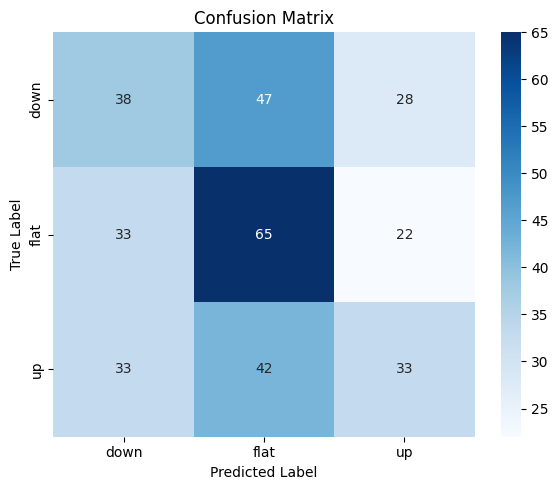

In [356]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05, future_days=10)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

Epoch 1 - Loss: 51.9200
Epoch 2 - Loss: 50.2783
Epoch 3 - Loss: 50.0453
Epoch 4 - Loss: 50.2245
Epoch 5 - Loss: 50.2249
Epoch 6 - Loss: 50.1278
Epoch 7 - Loss: 49.8759
Epoch 8 - Loss: 50.0226
Epoch 9 - Loss: 50.1913
Epoch 10 - Loss: 49.8532
Epoch 11 - Loss: 50.1132
Epoch 12 - Loss: 50.1250
Epoch 13 - Loss: 50.0838
Epoch 14 - Loss: 50.0208
Epoch 15 - Loss: 50.0118
Epoch 16 - Loss: 50.0185
Epoch 17 - Loss: 50.0181
Epoch 18 - Loss: 49.7694
Epoch 19 - Loss: 49.8349
Epoch 20 - Loss: 49.9242
Epoch 21 - Loss: 49.9597
Epoch 22 - Loss: 50.0396
Epoch 23 - Loss: 49.7292
Epoch 24 - Loss: 49.5862
Epoch 25 - Loss: 49.8246
Epoch 26 - Loss: 49.9965
Epoch 27 - Loss: 49.8652
Epoch 28 - Loss: 50.0148
Epoch 29 - Loss: 49.8554
Epoch 30 - Loss: 49.6519
Epoch 31 - Loss: 49.7632
Epoch 32 - Loss: 49.5942
Epoch 33 - Loss: 49.8581
Epoch 34 - Loss: 49.7959
Epoch 35 - Loss: 49.6430
Epoch 36 - Loss: 49.6158
Epoch 37 - Loss: 49.6156
Epoch 38 - Loss: 49.6678
Epoch 39 - Loss: 49.4889
Epoch 40 - Loss: 49.7329
Epoch 41 

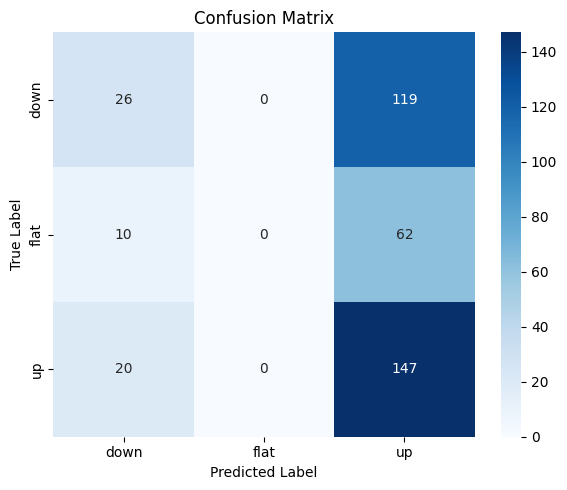

In [383]:
X, y_class = get_dataset_with_labels("New York, NY", "UNL", weather=False, label_window=5, threshold=0.02)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

Epoch 1 - Loss: 60.6788
Epoch 2 - Loss: 59.2624
Epoch 3 - Loss: 58.7416
Epoch 4 - Loss: 59.1960
Epoch 5 - Loss: 58.9144
Epoch 6 - Loss: 58.6450
Epoch 7 - Loss: 58.7836
Epoch 8 - Loss: 58.7670
Epoch 9 - Loss: 58.5157
Epoch 10 - Loss: 58.8315
Epoch 11 - Loss: 58.5381
Epoch 12 - Loss: 58.4766
Epoch 13 - Loss: 58.7060
Epoch 14 - Loss: 58.3402
Epoch 15 - Loss: 58.3884
Epoch 16 - Loss: 58.3019
Epoch 17 - Loss: 58.4335
Epoch 18 - Loss: 58.3356
Epoch 19 - Loss: 58.3302
Epoch 20 - Loss: 58.6496
Epoch 21 - Loss: 58.1543
Epoch 22 - Loss: 58.2056
Epoch 23 - Loss: 58.5319
Epoch 24 - Loss: 58.2180
Epoch 25 - Loss: 58.1591
Epoch 26 - Loss: 58.2405
Epoch 27 - Loss: 58.1091
Epoch 28 - Loss: 58.0213
Epoch 29 - Loss: 58.2499
Epoch 30 - Loss: 58.0288
Epoch 31 - Loss: 57.9733
Epoch 32 - Loss: 57.9211
Epoch 33 - Loss: 58.0826
Epoch 34 - Loss: 58.1219
Epoch 35 - Loss: 58.1086
Epoch 36 - Loss: 57.8704
Epoch 37 - Loss: 58.0154
Epoch 38 - Loss: 58.3289
Epoch 39 - Loss: 57.9037
Epoch 40 - Loss: 57.8695
Epoch 41 

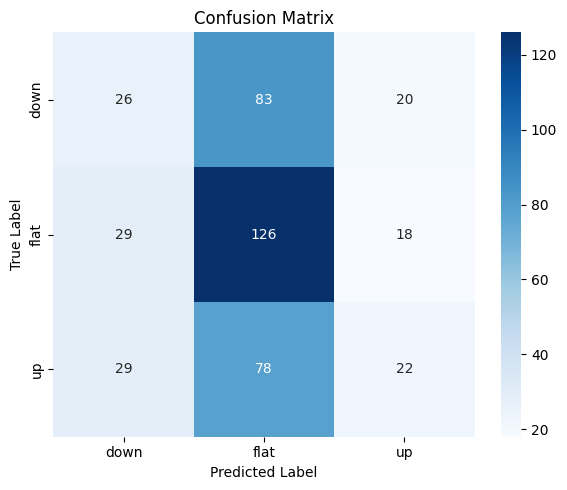

In [378]:
X, y_class = get_dataset_with_labels(cities[2], "UNG", weather=False, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

Epoch 1 - Loss: 60.4502
Epoch 2 - Loss: 59.2439
Epoch 3 - Loss: 58.5585
Epoch 4 - Loss: 58.7404
Epoch 5 - Loss: 58.1926
Epoch 6 - Loss: 58.0724
Epoch 7 - Loss: 57.8524
Epoch 8 - Loss: 57.6968
Epoch 9 - Loss: 57.6602
Epoch 10 - Loss: 57.3034
Epoch 11 - Loss: 57.0519
Epoch 12 - Loss: 57.1566
Epoch 13 - Loss: 56.9957
Epoch 14 - Loss: 56.8230
Epoch 15 - Loss: 56.5778
Epoch 16 - Loss: 56.2612
Epoch 17 - Loss: 56.0632
Epoch 18 - Loss: 55.9565
Epoch 19 - Loss: 55.6793
Epoch 20 - Loss: 56.4992
Epoch 21 - Loss: 55.2486
Epoch 22 - Loss: 55.7981
Epoch 23 - Loss: 55.7847
Epoch 24 - Loss: 55.6022
Epoch 25 - Loss: 54.8405
Epoch 26 - Loss: 54.4899
Epoch 27 - Loss: 54.4075
Epoch 28 - Loss: 54.7179
Epoch 29 - Loss: 54.4636
Epoch 30 - Loss: 54.0741
Epoch 31 - Loss: 53.7015
Epoch 32 - Loss: 53.9234
Epoch 33 - Loss: 54.2524
Epoch 34 - Loss: 53.6924
Epoch 35 - Loss: 53.4432
Epoch 36 - Loss: 53.2128
Epoch 37 - Loss: 52.6222
Epoch 38 - Loss: 51.9436
Epoch 39 - Loss: 52.6769
Epoch 40 - Loss: 51.4313
Epoch 41 

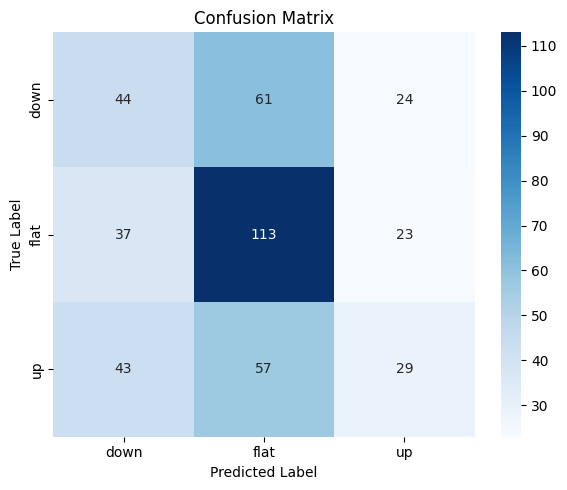

In [379]:
X, y_class = get_dataset_with_labels(cities[2], "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformerClassifier(input_dim=X.shape[1], num_classes=len(label_names)).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device, num_epochs=100, lr=0.001)

### cross attention

Epoch 1 - Loss: 53.0271
Epoch 2 - Loss: 52.7276
Epoch 3 - Loss: 52.7743
Epoch 4 - Loss: 52.7143
Epoch 5 - Loss: 52.7079
Epoch 6 - Loss: 52.6450
Epoch 7 - Loss: 52.7011
Epoch 8 - Loss: 52.6540
Epoch 9 - Loss: 52.5791
Epoch 10 - Loss: 52.5676
Epoch 11 - Loss: 52.6758
Epoch 12 - Loss: 52.6397
Epoch 13 - Loss: 52.5753
Epoch 14 - Loss: 52.5339
Epoch 15 - Loss: 52.5231
Epoch 16 - Loss: 52.5418
Epoch 17 - Loss: 52.5689
Epoch 18 - Loss: 52.7225
Epoch 19 - Loss: 52.5688
Epoch 20 - Loss: 52.5408
Epoch 21 - Loss: 52.5666
Epoch 22 - Loss: 52.5011
Epoch 23 - Loss: 52.4703
Epoch 24 - Loss: 52.4863
Epoch 25 - Loss: 52.5901
Epoch 26 - Loss: 52.5408
Epoch 27 - Loss: 52.6350
Epoch 28 - Loss: 52.5623
Epoch 29 - Loss: 52.5978
Epoch 30 - Loss: 52.4904
Epoch 31 - Loss: 52.4919
Epoch 32 - Loss: 52.5415
Epoch 33 - Loss: 52.5345
Epoch 34 - Loss: 52.6380
Epoch 35 - Loss: 52.5568
Epoch 36 - Loss: 52.4608
Epoch 37 - Loss: 52.4130
Epoch 38 - Loss: 52.5707
Epoch 39 - Loss: 52.5770
Epoch 40 - Loss: 52.6117
Epoch 41 

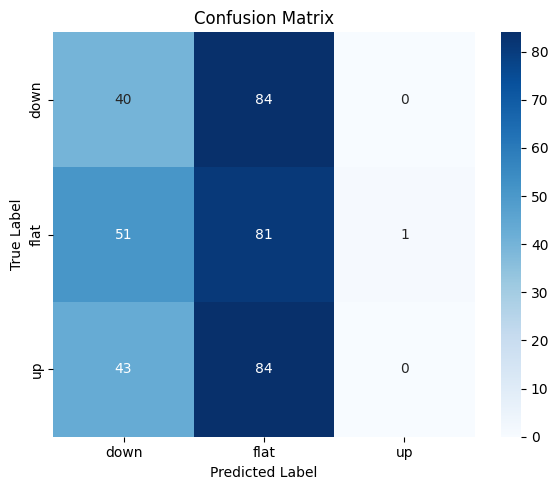

In [357]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=False, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 53.3106
Epoch 2 - Loss: 52.0652
Epoch 3 - Loss: 52.2336
Epoch 4 - Loss: 51.9456
Epoch 5 - Loss: 51.7735
Epoch 6 - Loss: 51.5868
Epoch 7 - Loss: 51.2505
Epoch 8 - Loss: 51.2400
Epoch 9 - Loss: 51.6667
Epoch 10 - Loss: 51.1988
Epoch 11 - Loss: 50.9485
Epoch 12 - Loss: 51.1269
Epoch 13 - Loss: 50.8940
Epoch 14 - Loss: 50.5601
Epoch 15 - Loss: 51.4733
Epoch 16 - Loss: 50.7782
Epoch 17 - Loss: 50.7818
Epoch 18 - Loss: 50.9130
Epoch 19 - Loss: 50.4601
Epoch 20 - Loss: 50.4084
Epoch 21 - Loss: 50.8713
Epoch 22 - Loss: 50.3970
Epoch 23 - Loss: 50.3020
Epoch 24 - Loss: 50.3126
Epoch 25 - Loss: 50.1131
Epoch 26 - Loss: 50.6179
Epoch 27 - Loss: 50.4661
Epoch 28 - Loss: 50.1674
Epoch 29 - Loss: 49.5770
Epoch 30 - Loss: 50.1295
Epoch 31 - Loss: 50.7254
Epoch 32 - Loss: 49.9053
Epoch 33 - Loss: 50.1287
Epoch 34 - Loss: 50.0879
Epoch 35 - Loss: 50.1425
Epoch 36 - Loss: 49.9743
Epoch 37 - Loss: 50.3808
Epoch 38 - Loss: 50.1098
Epoch 39 - Loss: 49.4362
Epoch 40 - Loss: 49.0635
Epoch 41 

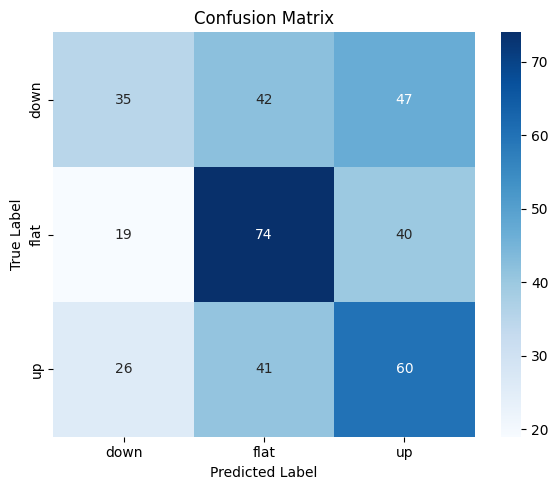

In [358]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)


Epoch 1 - Loss: 48.9685
Epoch 2 - Loss: 46.4982
Epoch 3 - Loss: 46.0644
Epoch 4 - Loss: 45.5819
Epoch 5 - Loss: 46.2835
Epoch 6 - Loss: 45.1493
Epoch 7 - Loss: 44.8765
Epoch 8 - Loss: 45.2768
Epoch 9 - Loss: 44.8790
Epoch 10 - Loss: 44.8904
Epoch 11 - Loss: 44.3245
Epoch 12 - Loss: 44.3496
Epoch 13 - Loss: 44.5917
Epoch 14 - Loss: 43.7104
Epoch 15 - Loss: 43.1215
Epoch 16 - Loss: 43.8387
Epoch 17 - Loss: 43.5740
Epoch 18 - Loss: 43.7057
Epoch 19 - Loss: 42.8851
Epoch 20 - Loss: 43.0033
Epoch 21 - Loss: 42.5920
Epoch 22 - Loss: 42.8992
Epoch 23 - Loss: 43.0603
Epoch 24 - Loss: 42.2946
Epoch 25 - Loss: 42.2713
Epoch 26 - Loss: 41.7732
Epoch 27 - Loss: 42.5471
Epoch 28 - Loss: 42.3211
Epoch 29 - Loss: 41.3778
Epoch 30 - Loss: 41.3314
Epoch 31 - Loss: 41.8097
Epoch 32 - Loss: 42.2167
Epoch 33 - Loss: 44.4734
Epoch 34 - Loss: 43.6092
Epoch 35 - Loss: 42.0087
Epoch 36 - Loss: 41.6593
Epoch 37 - Loss: 41.4010
Epoch 38 - Loss: 40.8584
Epoch 39 - Loss: 40.4690
Epoch 40 - Loss: 40.2004
Epoch 41 

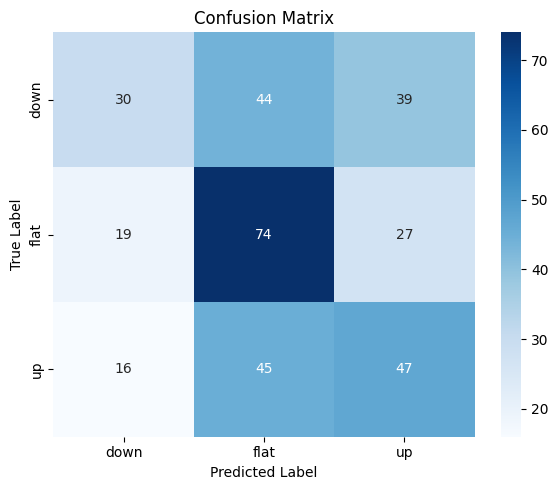

In [369]:
X, y_class = get_dataset_with_labels("New York, NY", "UNG", weather=True, label_window=5, threshold=0.05, future_days=10)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)


Epoch 1 - Loss: 50.8130
Epoch 2 - Loss: 50.3770
Epoch 3 - Loss: 50.4823
Epoch 4 - Loss: 50.2663
Epoch 5 - Loss: 50.4030
Epoch 6 - Loss: 50.2866
Epoch 7 - Loss: 50.4298
Epoch 8 - Loss: 50.2420
Epoch 9 - Loss: 50.2939
Epoch 10 - Loss: 50.4225
Epoch 11 - Loss: 50.1872
Epoch 12 - Loss: 50.4511
Epoch 13 - Loss: 50.2182
Epoch 14 - Loss: 50.4402
Epoch 15 - Loss: 50.2704
Epoch 16 - Loss: 50.2694
Epoch 17 - Loss: 50.3340
Epoch 18 - Loss: 50.1478
Epoch 19 - Loss: 50.1854
Epoch 20 - Loss: 50.1685
Epoch 21 - Loss: 49.9037
Epoch 22 - Loss: 50.1465
Epoch 23 - Loss: 50.0842
Epoch 24 - Loss: 50.1094
Epoch 25 - Loss: 50.0785
Epoch 26 - Loss: 50.1183
Epoch 27 - Loss: 50.2244
Epoch 28 - Loss: 50.0453
Epoch 29 - Loss: 50.1104
Epoch 30 - Loss: 49.9467
Epoch 31 - Loss: 50.0783
Epoch 32 - Loss: 50.2895
Epoch 33 - Loss: 50.0129
Epoch 34 - Loss: 49.8308
Epoch 35 - Loss: 49.8039
Epoch 36 - Loss: 49.8067
Epoch 37 - Loss: 49.8890
Epoch 38 - Loss: 49.8472
Epoch 39 - Loss: 49.9992
Epoch 40 - Loss: 49.5961
Epoch 41 

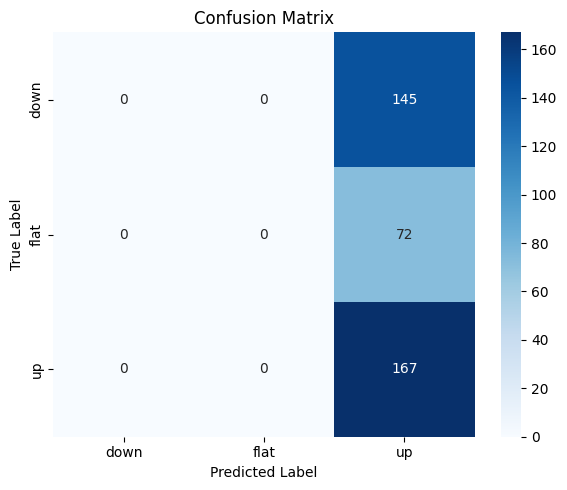

In [384]:
X, y_class = get_dataset_with_labels("New York, NY", "UNL", weather=False, label_window=5, threshold=0.02)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 59.4095
Epoch 2 - Loss: 59.0874
Epoch 3 - Loss: 59.1036
Epoch 4 - Loss: 59.0945
Epoch 5 - Loss: 59.0237
Epoch 6 - Loss: 58.9340
Epoch 7 - Loss: 59.0408
Epoch 8 - Loss: 58.8994
Epoch 9 - Loss: 58.9451
Epoch 10 - Loss: 58.9795
Epoch 11 - Loss: 58.8279
Epoch 12 - Loss: 58.8729
Epoch 13 - Loss: 59.0779
Epoch 14 - Loss: 58.8957
Epoch 15 - Loss: 58.9174
Epoch 16 - Loss: 58.8781
Epoch 17 - Loss: 58.9128
Epoch 18 - Loss: 58.8816
Epoch 19 - Loss: 58.9081
Epoch 20 - Loss: 58.8517
Epoch 21 - Loss: 58.8761
Epoch 22 - Loss: 58.8702
Epoch 23 - Loss: 58.8462
Epoch 24 - Loss: 58.8698
Epoch 25 - Loss: 58.8540
Epoch 26 - Loss: 58.9212
Epoch 27 - Loss: 58.8628
Epoch 28 - Loss: 58.8424
Epoch 29 - Loss: 58.9346
Epoch 30 - Loss: 58.8587
Epoch 31 - Loss: 58.8376
Epoch 32 - Loss: 58.8489
Epoch 33 - Loss: 58.8578
Epoch 34 - Loss: 58.8457
Epoch 35 - Loss: 58.8631
Epoch 36 - Loss: 58.8233
Epoch 37 - Loss: 58.8572
Epoch 38 - Loss: 58.8713
Epoch 39 - Loss: 58.8513
Epoch 40 - Loss: 58.8242
Epoch 41 

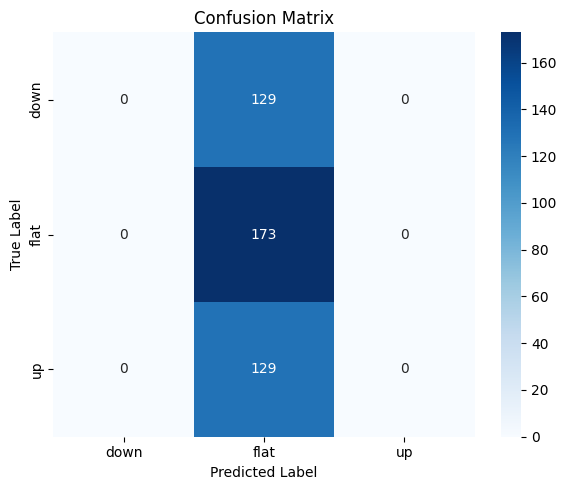

In [381]:
X, y_class = get_dataset_with_labels(cities[2], "UNG", weather=False, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 59.9029
Epoch 2 - Loss: 58.5592
Epoch 3 - Loss: 58.7537
Epoch 4 - Loss: 58.0324
Epoch 5 - Loss: 58.2398
Epoch 6 - Loss: 57.9416
Epoch 7 - Loss: 58.0510
Epoch 8 - Loss: 57.5430
Epoch 9 - Loss: 57.7118
Epoch 10 - Loss: 57.6772
Epoch 11 - Loss: 57.4661
Epoch 12 - Loss: 57.4114
Epoch 13 - Loss: 58.1573
Epoch 14 - Loss: 57.8923
Epoch 15 - Loss: 57.3392
Epoch 16 - Loss: 57.5131
Epoch 17 - Loss: 57.3627
Epoch 18 - Loss: 56.8699
Epoch 19 - Loss: 57.2592
Epoch 20 - Loss: 56.5036
Epoch 21 - Loss: 56.6578
Epoch 22 - Loss: 57.0292
Epoch 23 - Loss: 57.1697
Epoch 24 - Loss: 56.9122
Epoch 25 - Loss: 56.6712
Epoch 26 - Loss: 57.1648
Epoch 27 - Loss: 57.1896
Epoch 28 - Loss: 56.7541
Epoch 29 - Loss: 56.3851
Epoch 30 - Loss: 56.4302
Epoch 31 - Loss: 56.4482
Epoch 32 - Loss: 56.3864
Epoch 33 - Loss: 56.6175
Epoch 34 - Loss: 56.1860
Epoch 35 - Loss: 56.3035
Epoch 36 - Loss: 56.1816
Epoch 37 - Loss: 56.2820
Epoch 38 - Loss: 56.4781
Epoch 39 - Loss: 55.6644
Epoch 40 - Loss: 55.8784
Epoch 41 

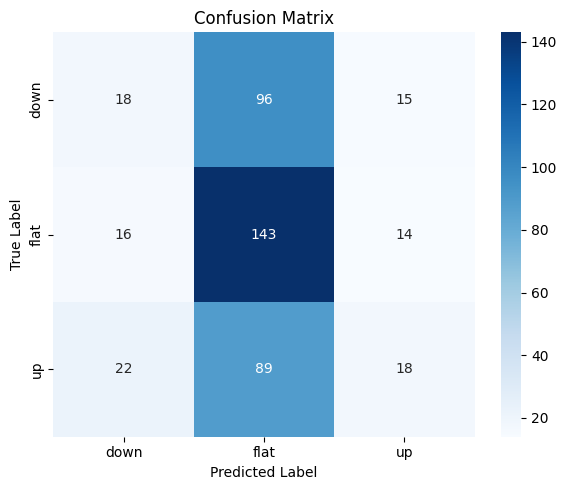

In [382]:
X, y_class = get_dataset_with_labels(cities[2], "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

In [390]:
cities

['New York, NY', 'Chicago, IL', 'Dallas, TX', 'Boston, MA', 'Minneapolis, MN']

Epoch 1 - Loss: 59.8966
Epoch 2 - Loss: 58.6128
Epoch 3 - Loss: 58.3128
Epoch 4 - Loss: 58.2005
Epoch 5 - Loss: 58.3628
Epoch 6 - Loss: 57.9593
Epoch 7 - Loss: 57.5689
Epoch 8 - Loss: 58.0015
Epoch 9 - Loss: 57.6539
Epoch 10 - Loss: 57.5303
Epoch 11 - Loss: 57.7382
Epoch 12 - Loss: 57.4059
Epoch 13 - Loss: 56.7422
Epoch 14 - Loss: 56.9643
Epoch 15 - Loss: 57.7910
Epoch 16 - Loss: 57.3226
Epoch 17 - Loss: 56.8568
Epoch 18 - Loss: 57.1362
Epoch 19 - Loss: 56.6249
Epoch 20 - Loss: 56.6366
Epoch 21 - Loss: 56.9050
Epoch 22 - Loss: 56.7630
Epoch 23 - Loss: 56.7328
Epoch 24 - Loss: 56.8949
Epoch 25 - Loss: 56.4979
Epoch 26 - Loss: 56.5166
Epoch 27 - Loss: 56.4036
Epoch 28 - Loss: 56.7129
Epoch 29 - Loss: 56.2700
Epoch 30 - Loss: 55.8158
Epoch 31 - Loss: 56.0572
Epoch 32 - Loss: 56.2744
Epoch 33 - Loss: 56.8255
Epoch 34 - Loss: 55.8434
Epoch 35 - Loss: 56.2328
Epoch 36 - Loss: 55.9252
Epoch 37 - Loss: 56.0774
Epoch 38 - Loss: 55.9734
Epoch 39 - Loss: 55.8479
Epoch 40 - Loss: 55.3582
Epoch 41 

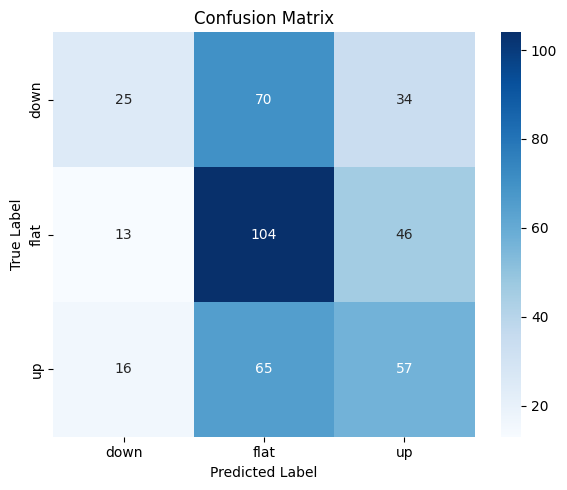

In [388]:
X, y_class = get_dataset_with_labels(cities[4], "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

Epoch 1 - Loss: 59.9742
Epoch 2 - Loss: 58.7192
Epoch 3 - Loss: 58.9249
Epoch 4 - Loss: 58.5251
Epoch 5 - Loss: 58.6169
Epoch 6 - Loss: 58.4217
Epoch 7 - Loss: 58.2011
Epoch 8 - Loss: 58.3966
Epoch 9 - Loss: 58.2839
Epoch 10 - Loss: 57.9338
Epoch 11 - Loss: 57.8209
Epoch 12 - Loss: 58.0293
Epoch 13 - Loss: 57.8597
Epoch 14 - Loss: 57.9300
Epoch 15 - Loss: 57.7696
Epoch 16 - Loss: 57.5969
Epoch 17 - Loss: 57.8682
Epoch 18 - Loss: 57.7723
Epoch 19 - Loss: 57.6798
Epoch 20 - Loss: 58.0851
Epoch 21 - Loss: 57.6110
Epoch 22 - Loss: 57.7330
Epoch 23 - Loss: 57.3264
Epoch 24 - Loss: 57.1293
Epoch 25 - Loss: 57.2471
Epoch 26 - Loss: 57.2731
Epoch 27 - Loss: 57.6150
Epoch 28 - Loss: 57.4487
Epoch 29 - Loss: 57.2734
Epoch 30 - Loss: 57.0855
Epoch 31 - Loss: 56.7524
Epoch 32 - Loss: 57.2135
Epoch 33 - Loss: 56.8190
Epoch 34 - Loss: 56.6501
Epoch 35 - Loss: 57.0137
Epoch 36 - Loss: 56.7689
Epoch 37 - Loss: 56.4499
Epoch 38 - Loss: 56.9006
Epoch 39 - Loss: 56.9881
Epoch 40 - Loss: 56.7277
Epoch 41 

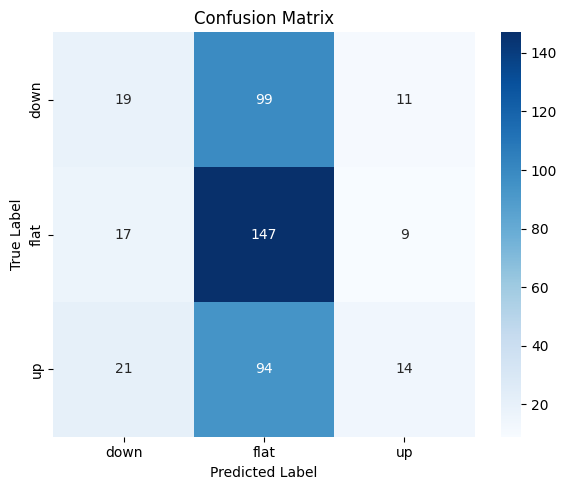

In [385]:
X, y_class = get_dataset_with_labels(cities[3], "UNG", weather=True, label_window=5, threshold=0.05)
train_loader, test_loader, label_names = get_datasets_for_dl(X, y_class)
model = CrossAttentionModel(price_dim=5, weather_dim=X.shape[1]-5, num_classes=3).to(device)
train_evaluation(model, train_loader, test_loader, label_names, device)

### reg

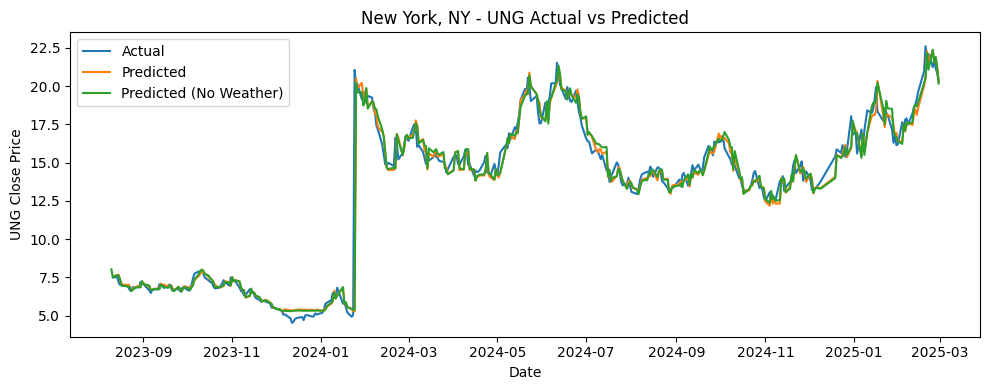

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.plot(y_test_nw.index, y_pred_nw, label='Predicted (No Weather)')
plt.title(f"{city} - {ticker} Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel(f"{ticker} Close Price")
plt.legend()
plt.tight_layout()
plt.show()